### Basic Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

dist =torch.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
pt1 = torch.tensor([[1.0, 0.0],
                    [1.0, 0.0],
                    [1.0, 0.0],
                    [1.0, 0.0]
                    ])
pt2 = torch.tensor([[0.5, 0.5],
                    [0.5, 0.5],
                    [0.5, 0.5],
                    [0.5, 0.5]
                    ])
pt3 = torch.tensor([[0.0, 1.0],
                    [1.0, 0.0],
                    [0.0, 1.0],
                    [1.0, 0.0]
                    ])


In [3]:
def avg_prob(pt):
    return torch.mean(pt, dim=0)

avg_prob(pt1), avg_prob(pt2), avg_prob(pt3)

(tensor([1., 0.]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]))

In [4]:
def predictive_entropy(pt):
    avg = avg_prob(pt)
    return -torch.sum(avg * torch.log2(avg))


In [5]:
predictive_entropy(pt1), predictive_entropy(pt2), predictive_entropy(pt3)

(tensor(nan), tensor(1.), tensor(1.))

In [6]:
# Numerically stable version to compute entropy by avoiding log(0)
def predictive_entropy(pt):
    avg = avg_prob(pt)
    return -torch.sum(avg * torch.log2(avg + 1e-8))

predictive_entropy(pt1), predictive_entropy(pt2), predictive_entropy(pt3)

(tensor(-0.), tensor(1.), tensor(1.))

In [7]:
def expected_entropy(pt):
    return torch.mean(torch.sum(-pt * torch.log2(pt + 1e-8), dim=1))

expected_entropy(pt1), expected_entropy(pt2), expected_entropy(pt3)

(tensor(0.), tensor(1.), tensor(0.))

In [8]:
def mutual_information(pt):
    return predictive_entropy(pt) - expected_entropy(pt)

mutual_information(pt1), mutual_information(pt2), mutual_information(pt3)

(tensor(-0.), tensor(0.), tensor(1.))

### Example from Gal et al.

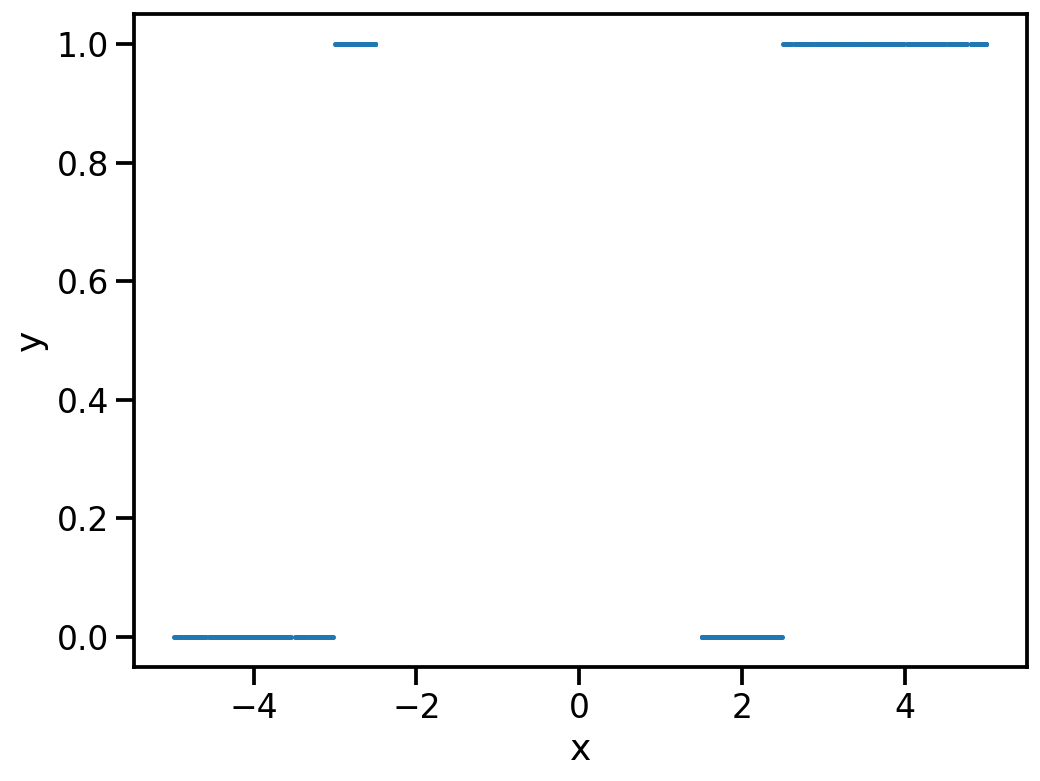

In [9]:
# Training data

# Between -5 and -3, y = 0, and we have n1 = 1000
# Between -3 and -2, y = 1, and we have n2 = 500
# Between 1 and 2.5, y = 0, and we have n3 = 750
# Between 2.5 and 5, y = 1, and we have n4 = 1250

fac = 4
# Generate data
n1 = 1000//fac
n2 = 500//fac
n3 = 750//fac
n4 = 1250//fac

x1 = dist.Uniform(-5, -3).sample((n1,))
x2 = dist.Uniform(-3, -2.5).sample((n2,))
x3 = dist.Uniform(1.5, 2.5).sample((n3,))
x4 = dist.Uniform(2.5, 5).sample((n4,))

x = torch.cat([x1, x2, x3, x4])
y = torch.cat([torch.zeros(n1), torch.ones(n2), torch.zeros(n3), torch.ones(n4)])

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1)
plt.xlabel("x")
plt.ylabel("y")

# Move to GPU
x = x.cuda()
y = y.cuda()

In [11]:
# Simple MLP with 4 layers and dropout in between

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [15]:
# Training loop

def train(model, x, y, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred.squeeze(), y)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.4f}")

# Train the model
model = MLP(1, 32, 1, 0.2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
train(model, x.unsqueeze(1), y, optimizer, loss_fn, 4000)

Epoch 0, loss 0.6576
Epoch 100, loss 0.0542
Epoch 200, loss 0.0323
Epoch 300, loss 0.0404
Epoch 400, loss 0.0286
Epoch 500, loss 0.0115
Epoch 600, loss 0.0164
Epoch 700, loss 0.0181
Epoch 800, loss 0.0137
Epoch 900, loss 0.0131
Epoch 1000, loss 0.0165
Epoch 1100, loss 0.0095
Epoch 1200, loss 0.0173
Epoch 1300, loss 0.0118
Epoch 1400, loss 0.0110
Epoch 1500, loss 0.0146
Epoch 1600, loss 0.0109
Epoch 1700, loss 0.0082
Epoch 1800, loss 0.0067
Epoch 1900, loss 0.0102
Epoch 2000, loss 0.0164
Epoch 2100, loss 0.0059
Epoch 2200, loss 0.0075
Epoch 2300, loss 0.0077
Epoch 2400, loss 0.0081
Epoch 2500, loss 0.0046
Epoch 2600, loss 0.0072
Epoch 2700, loss 0.0032
Epoch 2800, loss 0.0081
Epoch 2900, loss 0.0244
Epoch 3000, loss 0.0132
Epoch 3100, loss 0.0139
Epoch 3200, loss 0.0121
Epoch 3300, loss 0.0105
Epoch 3400, loss 0.0051
Epoch 3500, loss 0.0146
Epoch 3600, loss 0.0150
Epoch 3700, loss 0.0058
Epoch 3800, loss 0.0131
Epoch 3900, loss 0.0029


In [18]:
# At test time, we want to use MC dropout to get the predictive distribution

def predict(model, x, num_mc_samples):
    model.train()
    y_preds = []
    for _ in range(num_mc_samples):
        y_pred = torch.sigmoid(model(x.unsqueeze(1)))
        y_preds.append(y_pred.detach().cpu().numpy())
    return np.concatenate(y_preds, axis=1)

# Plot the predictive distribution
x_test = torch.linspace(-5, 5, 1000).cuda()
y_test = predict(model, x_test, 2000) # 500 MC samples


In [19]:
y_test_orig = torch.from_numpy(y_test)
y_test_orig.shape

torch.Size([1000, 2000])

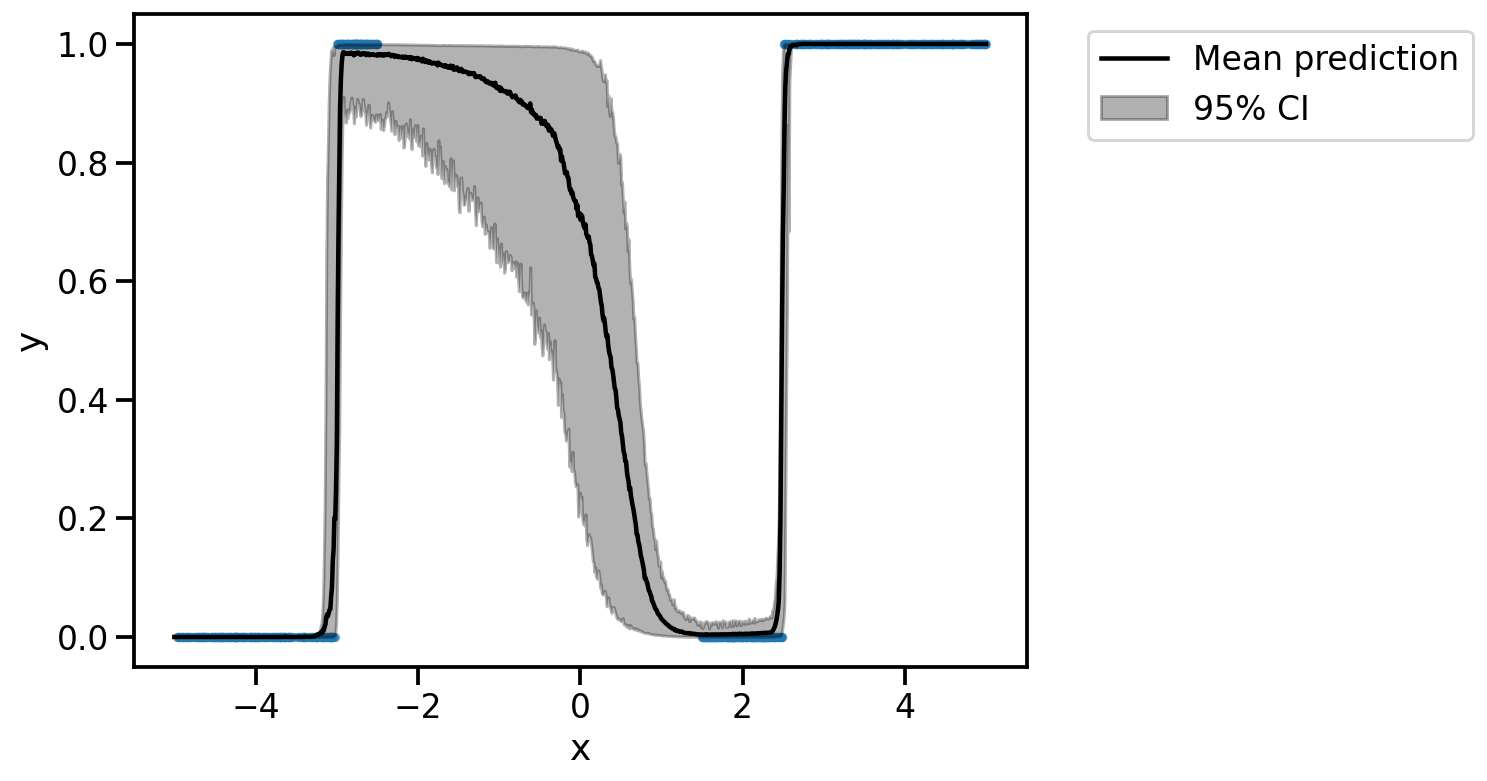

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(x.cpu(), y.cpu(), s=10, alpha=0.5)
plt.plot(x_test.cpu(), torch.mean(y_test_orig, axis=1).cpu(), color="black", label="Mean prediction")
plt.fill_between(x_test.cpu(), np.percentile(y_test_orig.cpu(), 2.5, axis=1), np.percentile(y_test_orig.cpu(), 97.5, axis=1), alpha=0.3, color="black", label="95% CI")
plt.xlabel("x")
plt.ylabel("y")
# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [24]:
y_test_orig

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [25]:
# Convert y_test to (n_samples, n_mc_samples, n_classes)
y_test = torch.stack([1 - y_test_orig, y_test_orig], axis=2)

y_test.shape

torch.Size([1000, 2000, 2])

In [26]:
# Compute the predictive entropy for a single example
predictive_entropy(y_test[0])

tensor(2.8551e-22)

In [27]:
# Find MI for a single example
mutual_information(y_test[0])

tensor(2.5244e-29)

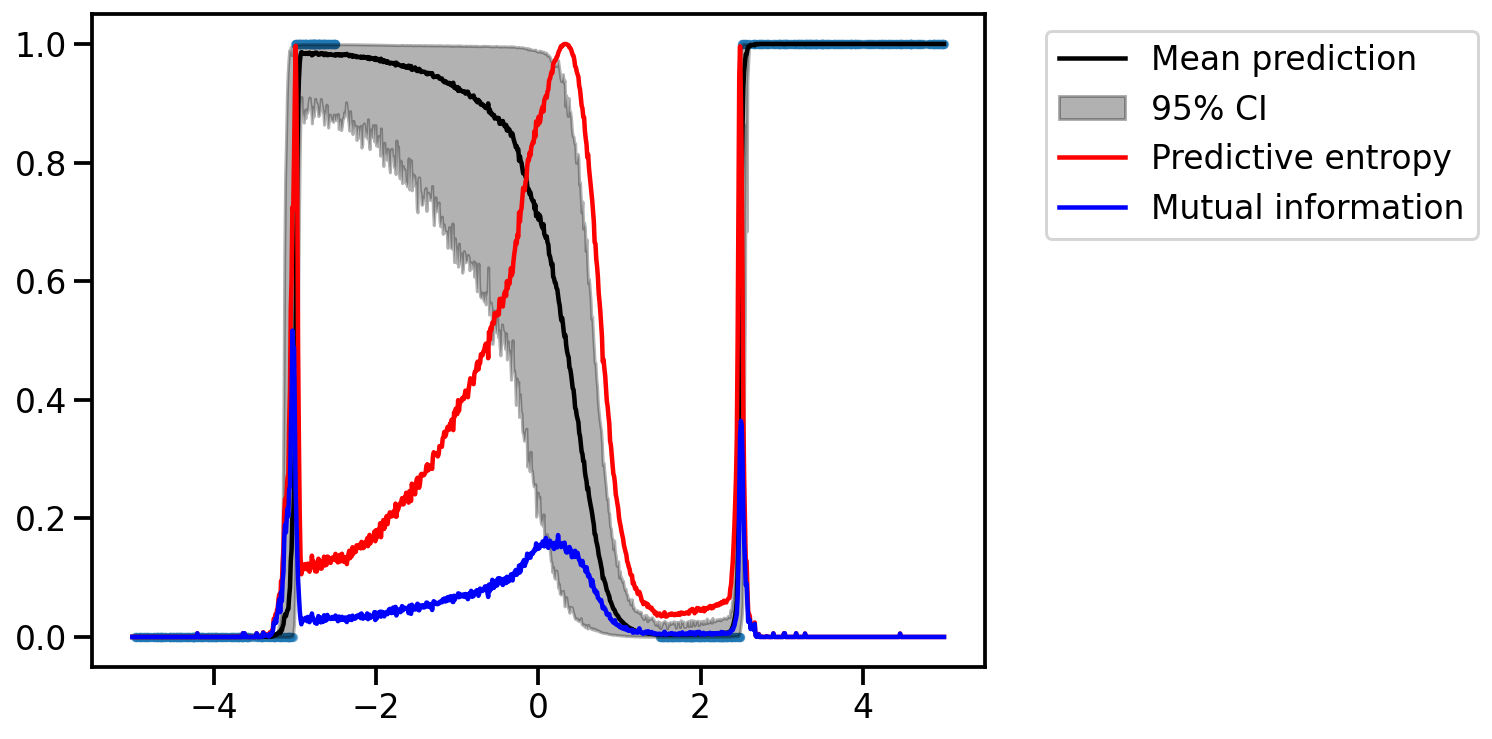

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(x.cpu(), y.cpu(), s=10, alpha=0.5)
plt.plot(x_test.cpu(), torch.mean(y_test_orig, axis=1).cpu(), color="black", label="Mean prediction")
plt.fill_between(x_test.cpu(), np.percentile(y_test_orig.cpu(), 2.5, axis=1), np.percentile(y_test_orig.cpu(), 97.5, axis=1), alpha=0.3, color="black", label="95% CI")
# Use vmap from torch to compute the predictive entropy for all examples
pred_entropy_vals = torch.func.vmap(predictive_entropy)(y_test)
plt.plot(x_test.cpu(), pred_entropy_vals, color="red", label="Predictive entropy")

# Use vmap from torch to compute the mutual information for all examples
mi_vals = torch.func.vmap(mutual_information)(y_test)
plt.plot(x_test.cpu(), mi_vals, color="blue", label="Mutual information")

# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')